# Data Loading


In [63]:
#importing necessery libraries for future analysis of the dataset
import folium
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as plt
import seaborn as sns
import time
import numpy as np


## Function

### Transform files

These funtions below are used to read and transform data into readable df.

How To Use:

For transforming acceleromter and gyroscope data, please use `transform_data_acceleration(file, format)`, for:
- file: Pfad to file 
- format: json or csv

Example: 
```python
ubahn1_df = transform_data_acceleration('Data/Ubahn/Json/ubahn1.json','json')
ubahn2_df = transform_data_acceleration('Data/Ubahn/Json/ubahn2.json','json')
ubahn3_df = transform_data_acceleration('Data/Ubahn/Json/ubahn3.json','json')
```
For transforming location data, please use `transform_data_location(file, format, type)`, for:
- file: Pfad to file 
- format: json or csv
- type: Type of traffic (Ubahn, Bus, Auto, etc)

Example:
`ubahn1_df_loc = transform_data_location('Data/Ubahn/Json/ubahn1.json','json', 'ubahn')`

In [64]:
#Tranform accelerometer and gyroscope data to one dataframe
def transform_data_acceleration(file, format):
    if format == 'json':
        df = pd.read_json(file)
    else:
        df = pd.read_csv(file)  
        
    acce = df[df['sensor'] == 'Accelerometer']
    acce.reset_index(drop=True, inplace=True)   
    acce = acce.drop(columns =['seconds_elapsed','sensor', 'relativeAltitude', 'pressure', 'altitude', 'speedAccuracy', 'bearingAccuracy', 'latitude', 'altitudeAboveMeanSeaLevel', 'bearing', 'horizontalAccuracy', 'verticalAccuracy', 'longitude', 'speed', 'version', 'device name', 'recording time', 'platform', 'appVersion', 'device id', 'sensors', 'sampleRateMs', 'yaw', 'qx', 'qz', 'roll', 'qw', 'qy', 'pitch'])
    acce['Magnitude_acce'] = np.sqrt(acce["x"] ** 2 + acce["y"] ** 2 + acce["z"] ** 2)
    
    gyro = df[df['sensor'] == 'Gyroscope']
    gyro.reset_index(drop=True, inplace=True)   
    gyro = gyro.drop(columns = ['seconds_elapsed','sensor', 'relativeAltitude', 'pressure', 'altitude', 'speedAccuracy', 'bearingAccuracy', 'latitude', 'altitudeAboveMeanSeaLevel', 'bearing', 'horizontalAccuracy', 'verticalAccuracy', 'longitude', 'speed', 'version', 'device name', 'recording time', 'platform', 'appVersion', 'device id', 'sensors', 'sampleRateMs', 'yaw', 'qx', 'qz', 'roll', 'qw', 'qy', 'pitch'])
    

    for df in [gyro, acce]:
         df.index = pd.to_datetime(df['time'], unit = 'ns',errors='ignore')
         df.drop(columns=['time'], inplace=True)
    #df_new = pd.merge(loc, gyro, suffixes=('_loc', '_gyro'), on='time')
    df_new = acce.join(gyro, lsuffix = '_acce', rsuffix = '_gyro', how = 'outer').interpolate()
   
    #df_new = pd.merge(pd.merge(loc, gyro, suffixes=('_loc', '_gyro'), on='time'), acce, suffixes=('', '_acce'), on='time')
    #df_new['Type'] = type
    
    return df_new

In [65]:
#Tranform location from file
def transform_data_location(file, format):
    if format == 'json':
        df = pd.read_json(file)
    else:
        df = pd.read_csv(file)   

    location = df[df['sensor'] == 'Location']
    location.reset_index(drop=True, inplace=True)
    location = location.drop(columns = ['sensor', 'z', 'y', 'x', 'relativeAltitude', 'pressure', 'version', 
                                        'device name', 'recording time', 'platform', 'appVersion', 'device id', 'sensors', 'sampleRateMs', 'yaw', 'qx', 'qz', 'roll', 'qw', 'qy', 'pitch'])
    #Speed using abs to positive
    
    location.index = pd.to_datetime(location['time'], unit = 'ns',errors='ignore')
    location.drop(columns=['time'], inplace=True)
    #location['Type'] = type
    return location

In [66]:
# Transform accelleration and gyro data for .csv files
def transform_data_accelleration_csv(file, format):
    if format != "csv":
        print("Use other function for .json data")

    acce = pd.read_csv(file)
    acce.reset_index(drop=True, inplace=True) 
    acce['Magnitude_acce'] = np.sqrt(acce["x"] ** 2 + acce["y"] ** 2 + acce["z"] ** 2)
    acce.drop(["x", "y", "z","seconds_elapsed"], axis=1, inplace=True)
    for df in [acce]:
         df.index = pd.to_datetime(df['time'], unit = 'ns',errors='ignore')
         df.drop(columns=['time'], inplace=True)
    return acce

def transform_data_gyroscope_csv(file, format):
    if format != "csv":
        print("Use other function for .json data")
    gyro = pd.read_csv(file)
    gyro.reset_index(drop=True, inplace=True)
    gyro.drop(['seconds_elapsed'], axis=1, inplace=True)
    for df in [gyro]:
         df.index = pd.to_datetime(df['time'], unit = 'ns',errors='ignore')
         df.drop(columns=['time'], inplace=True)
    return gyro


### Compute features of the data based on 5s temporal window.
These funtions below are used to find min, max, average, and standard deviation values for each 5s time period.
How To Use:

After tranforming all dataframes using transform_data_acceleration, combine the dataframes into a single dataframe, for example:

`dfs = [ubahn1_df, ubahn2_df, ubahn3_df]`


Then using `combine_into_df(dfs, type)` function, for:
- dfs as defined above 
- type as type of transport 

Example:
`df = combine_into_df(dfs, 'ubahn')`


Result returns the following columns:
- Time
- Magnitude_acce_min
- Magnitude_acce_max
- Magnitude_acce_mean
- Magnitude_acce_std
- Type

In [315]:
#Cut data into windows of 5 seconds and calculate min, max, mean and std
def create_feature_df(df, type):   
    min_values = df.resample('13s').min(numeric_only=True)
    max_values = df.resample('13s').max(numeric_only=True)
    mean_values = df.resample('13s').mean(numeric_only=True)
    std_values = df.resample('13s').std(numeric_only=True)
    #columns_to_drop = df.columns.difference(['Magnitude_acce','speed','x_acce', 'x_gyro','y_acce', 'y_gyro', 'z_acce', 'z_gyro','x','y','z'])
    columns_to_drop = df.columns.difference(['Magnitude_acce', 'x_gyro', 'y_gyro', 'z_gyro'])
    for df in [min_values, max_values, mean_values, std_values]:
        df.drop(columns=columns_to_drop, inplace=True)
    feature_df = pd.merge(pd.merge(min_values, max_values, suffixes = ('_min', '_max'), on = 'time'), pd.merge(mean_values, std_values, suffixes = ('_mean', '_std'), on = 'time'), on = 'time')
    feature_df['Type'] = type

    return feature_df

In [185]:
#Combine windows data into one DataFrame (only in case there are more than one df)
def combine_into_df(dfs, type):
    combined_df = pd.concat([create_feature_df(df, type) for df in dfs])  # Apply cut_into_window to each DataFrame and concatenate them
    #combined_df.reset_index(drop=True, inplace=True)  # Reset the index of the combined DataFrame
    return combined_df

In [69]:
#Combine windows data into one DataFrame (only in case there are more than one df)
def combine_with_loc(dfs_acce, dfs_loc):
    df_new = dfs_acce.join(dfs_loc, lsuffix = '', rsuffix = '_loc', how = 'outer').interpolate()
    return df_new


### Visualization

In [326]:
def map_data(df):
    coords = [(row.latitude, row.longitude) for _, row in df.iterrows()]
    my_map = folium.Map(location=[df.latitude.mean(), df.longitude.mean()], zoom_start=16)
    folium.PolyLine(coords, color="blue", weight=5.0).add_to(my_map)
    return my_map

In [327]:
map_data(ubahn1_loc)

### Code here:

### Read data for ubahn

In [71]:
#Read date for ubahn
ubahn1_df = transform_data_acceleration('Data/Ubahn/Json/ubahn1.json','json')
ubahn2_df = transform_data_acceleration('Data/Ubahn/Json/ubahn2.json','json')
ubahn3_df = transform_data_acceleration('Data/Ubahn/Json/ubahn3.json','json')
ubahn4_df = transform_data_acceleration('Data/Ubahn/Json/ubahn4.json','json')
ubahn5_df = transform_data_acceleration('Data/Ubahn/Json/ubahn5.json','json')
ubahn6_df = transform_data_acceleration('Data/Ubahn/Json/ubahn6.json','json')
ubahn7_df = transform_data_acceleration('Data/Ubahn/Json/ubahn7.json','json')


In [73]:
ubahn1_loc = transform_data_location('Data/Ubahn/Json/ubahn1.json','json')

In [303]:
dfs = [ubahn1_df, ubahn2_df, ubahn3_df, ubahn4_df, ubahn5_df, ubahn6_df, ubahn7_df]
ubahn_df = combine_into_df(dfs, 'ubahn')
ubahn_df.head()

,Magnitude_acce_min,z_gyro_min,y_gyro_min,x_gyro_min,Magnitude_acce_max,z_gyro_max,y_gyro_max,x_gyro_max,Magnitude_acce_mean,z_gyro_mean,y_gyro_mean,x_gyro_mean,Magnitude_acce_std,z_gyro_std,y_gyro_std,x_gyro_std,Type
time,,,,,,,,,,,,,,,,,
2023-05-24 06:21:58,0.011757,-0.849965,-0.605684,-0.848823,2.991935,0.393243,1.127046,0.752091,0.455436,-0.019187,0.003473,0.001553,0.306573,0.132364,0.187961,0.147434,ubahn
2023-05-24 06:22:12,0.006873,-4.469584,-3.980495,-2.605372,7.889453,2.135097,3.224050,2.306827,1.009773,0.004723,-0.020124,-0.005535,1.144893,0.469592,0.517211,0.451657,ubahn
2023-05-24 06:22:26,0.016555,-0.786553,-0.995960,-1.290184,4.276001,0.382618,1.105281,1.009378,0.518698,0.021392,0.016374,0.000783,0.420098,0.097354,0.114496,0.158204,ubahn
2023-05-24 06:22:40,0.021717,-0.069388,-0.035675,-0.094711,0.831970,0.117326,0.088247,0.142582,0.305175,0.011202,0.024281,0.001485,0.132983,0.044488,0.039133,0.033293,ubahn
2023-05-24 06:22:54,0.015605,-0.088832,-0.042471,-0.180307,2.455776,0.059165,0.096537,0.383132,0.339471,0.000482,-0.003717,-0.001864,0.282271,0.015621,0.011359,0.047701,ubahn


In [164]:
ubahn_df.isnull().sum() 

Magnitude_acce_min     0
z_gyro_min             0
y_gyro_min             0
x_gyro_min             0
Magnitude_acce_max     0
z_gyro_max             0
y_gyro_max             0
x_gyro_max             0
Magnitude_acce_mean    0
z_gyro_mean            0
y_gyro_mean            0
x_gyro_mean            0
Magnitude_acce_std     0
z_gyro_std             0
y_gyro_std             0
x_gyro_std             0
Type                   0
dtype: int64

### Read data for fahrrad

In [87]:
#Read data for fahrrad
fahrrad2_df = transform_data_acceleration('/Users/tramduong/Desktop/Python/GitHub/MaennerML-1/Data/Fahrrad/Fahrrad2.json','json')
fahrrad3_df = transform_data_acceleration('/Users/tramduong/Desktop/Python/GitHub/MaennerML-1/Data/Fahrrad/Fahrrad3.json','json')
fahrrad2_df.head()

,z_acce,y_acce,x_acce,Magnitude_acce,z_gyro,y_gyro,x_gyro
time,,,,,,,
2023-05-24 10:57:22.707848960,-0.145448,0.027461,0.008292,0.148250,-0.022874,-0.059316,0.021992
2023-05-24 10:57:22.717913856,-0.126788,0.007323,0.009061,0.127322,-0.015238,-0.061070,0.017357
2023-05-24 10:57:22.727979008,0.008563,-0.037565,-0.029014,0.048231,-0.007340,-0.054365,-0.009055
2023-05-24 10:57:22.738043904,0.168166,-0.065213,-0.043134,0.185454,-0.001951,-0.048770,-0.041461
2023-05-24 10:57:22.748108800,0.212968,-0.053833,0.012392,0.220016,0.007909,-0.064258,-0.060135


In [316]:
dfs = [fahrrad2_df, fahrrad3_df]
fahrrad_df = combine_into_df(dfs, 'fahrrad')
fahrrad_df.head()

,Magnitude_acce_min,z_gyro_min,y_gyro_min,x_gyro_min,Magnitude_acce_max,z_gyro_max,y_gyro_max,x_gyro_max,Magnitude_acce_mean,z_gyro_mean,y_gyro_mean,x_gyro_mean,Magnitude_acce_std,z_gyro_std,y_gyro_std,x_gyro_std,Type
time,,,,,,,,,,,,,,,,,
2023-05-24 10:57:22,0.014630,-5.260079,-4.786360,-2.388659,14.291444,6.922950,4.858806,2.705564,1.748325,0.057627,-0.118197,-0.030159,1.789623,1.170487,0.888800,0.701113,fahrrad
2023-05-24 10:57:35,0.018094,-2.909907,-7.830011,-2.811667,47.460605,2.489948,5.265118,3.222864,2.043220,-0.029714,0.028071,-0.090728,2.930090,0.658862,0.917052,0.703447,fahrrad
2023-05-24 10:57:48,0.101127,-1.792480,-3.264240,-3.781956,34.599911,1.377781,3.191617,6.146688,1.971752,-0.070410,0.013238,-0.052207,1.854537,0.579099,0.738366,0.921296,fahrrad
2023-05-24 10:58:01,0.125178,-1.757696,-1.503611,-2.919595,7.177719,1.976158,1.710698,1.787163,1.822210,0.056225,-0.018650,0.093052,0.940573,0.655917,0.615096,0.673809,fahrrad
2023-05-24 10:58:14,0.191234,-1.658468,-3.696768,-1.876602,8.144905,1.674394,2.051976,3.278327,2.397868,0.015634,-0.012648,0.087772,1.030497,0.582271,0.891317,0.676945,fahrrad


In [166]:
fahrrad_df.isnull().sum()

Magnitude_acce_min     0
z_gyro_min             0
y_gyro_min             0
x_gyro_min             0
Magnitude_acce_max     0
z_gyro_max             0
y_gyro_max             0
x_gyro_max             0
Magnitude_acce_mean    0
z_gyro_mean            0
y_gyro_mean            0
x_gyro_mean            0
Magnitude_acce_std     0
z_gyro_std             0
y_gyro_std             0
x_gyro_std             0
Type                   0
dtype: int64

### Read data for auto

In [140]:
def transform_data_accelleration_auto(file):
    df = pd.read_json(file)
    acce = df[df['sensor_acce'] == 'Accelerometer']
    acce.reset_index(drop=True, inplace=True)   
    acce['Magnitude_acce'] = np.sqrt(acce["x_acce"] ** 2 + acce["y_acce"] ** 2 + acce["z_acce"] ** 2)
    acce.rename(columns={"time_acce": "time"})

    gyro = df[df['sensor_gyro'] == 'Gyroscope']
    gyro.reset_index(drop=True, inplace=True)   
    #gyro.rename(columns={"x_gyro": "x", "y_gyro": "y", "z_gyro": "z"})
    
    for df in [gyro, acce]:
        df.index = pd.to_datetime(df['time'], unit = 'ns',errors='ignore')
     #df.drop(columns=columns_to_drop, inplace=True)
    df_new = acce.join(gyro, lsuffix = '', rsuffix = '_acce', how = 'outer').interpolate()
    columns_to_drop = df_new.columns.difference(['Magnitude_acce', 'x_gyro', 'y_gyro', 'z_gyro'])
    df_new.drop(columns=columns_to_drop, inplace=True)
    
    return df_new
    

In [93]:
auto1 = transform_data_acceleration('Data/Auto/auto1.json','json')

In [94]:
auto1.isnull().sum()

z_acce            0
y_acce            0
x_acce            0
Magnitude_acce    0
z_gyro            0
y_gyro            0
x_gyro            0
dtype: int64

In [141]:
auto2 = transform_data_accelleration_auto('Data/Auto/auto2.json')
auto3 = transform_data_accelleration_auto('Data/Auto/auto3.json')
auto4 = transform_data_accelleration_auto('Data/Auto/auto4.json')
auto5 = transform_data_accelleration_auto('Data/Auto/auto5.json')

In [142]:
auto2.head()

,z_gyro,y_gyro,x_gyro,Magnitude_acce
time,,,,
1970-01-01 00:28:07.693625322,0.155170,0.016860,0.039080,0.890620
1970-01-01 00:28:07.693625332,0.092678,-0.006801,-0.015387,0.777982
1970-01-01 00:28:07.693625342,0.037620,0.010245,-0.078696,0.730526
1970-01-01 00:28:07.693625352,0.002096,0.050164,-0.113451,0.718386
1970-01-01 00:28:07.693625362,-0.008282,0.098062,-0.122920,0.666354


In [317]:
dfs = [auto1, auto2, auto3, auto4, auto5]
auto_df = combine_into_df(dfs, 'auto')
auto_df.head()

,Magnitude_acce_min,z_gyro_min,y_gyro_min,x_gyro_min,Magnitude_acce_max,z_gyro_max,y_gyro_max,x_gyro_max,Magnitude_acce_mean,z_gyro_mean,y_gyro_mean,x_gyro_mean,Magnitude_acce_std,z_gyro_std,y_gyro_std,x_gyro_std,Type
time,,,,,,,,,,,,,,,,,
2023-06-25 11:38:19,0.045958,-0.050372,-0.065355,-0.213270,2.052202,0.057102,0.085141,0.238986,0.650136,-0.007905,0.002708,-0.007153,0.402232,0.022117,0.029094,0.083950,auto
2023-06-25 11:38:32,0.044099,-2.482766,-2.341649,-2.131080,7.324106,1.241009,5.313495,1.281950,0.987407,-0.059282,0.033530,-0.006261,0.927524,0.391634,0.474005,0.374646,auto
2023-06-25 11:38:45,0.086070,-0.561520,-1.427451,-0.842913,6.003701,0.742748,0.841474,1.180818,0.906020,-0.001823,-0.036328,0.029997,0.619631,0.113426,0.244972,0.252908,auto
2023-06-25 11:38:58,0.018567,-0.292989,-0.252220,-0.350230,1.985276,0.226719,0.350164,0.417823,0.646249,-0.007714,0.001242,-0.001031,0.334956,0.064786,0.084860,0.119943,auto
2023-06-25 11:39:11,0.022575,-0.198764,-0.318814,-0.468881,2.436404,0.186449,0.283259,0.526808,0.765702,-0.014947,-0.007127,0.001521,0.396502,0.063816,0.091455,0.133973,auto


In [168]:
auto_df.isnull().sum()  

Magnitude_acce_min     0
z_gyro_min             0
y_gyro_min             0
x_gyro_min             0
Magnitude_acce_max     0
z_gyro_max             0
y_gyro_max             0
x_gyro_max             0
Magnitude_acce_mean    0
z_gyro_mean            0
y_gyro_mean            0
x_gyro_mean            0
Magnitude_acce_std     0
z_gyro_std             0
y_gyro_std             0
x_gyro_std             0
Type                   0
dtype: int64

### Read data for bus

In [145]:
#Tranform accelerometer and gyroscope data to one dataframe
def transform_data_acceleration_bus(file, format):
    if format == 'json':
        df = pd.read_json(file)
    else:
        df = pd.read_csv(file)  
        
    acce = df[df['sensor'] == 'Accelerometer']
    acce.reset_index(drop=True, inplace=True)   
    acce = acce.drop(columns =['seconds_elapsed','sensor', 'altitude', 'speedAccuracy', 'bearingAccuracy', 'latitude',  'bearing', 'horizontalAccuracy', 'verticalAccuracy', 'longitude', 'speed', 'version', 'device name', 'recording time', 'platform', 'appVersion', 'device id', 'sensors', 'sampleRateMs', 'yaw', 'qx', 'qz', 'roll', 'qw', 'qy', 'pitch'])
    acce['Magnitude_acce'] = np.sqrt(acce["x"] ** 2 + acce["y"] ** 2 + acce["z"] ** 2)
    
    gyro = df[df['sensor'] == 'Gyroscope']
    gyro.reset_index(drop=True, inplace=True)   
    gyro = gyro.drop(columns = ['seconds_elapsed','sensor', 'altitude', 'speedAccuracy', 'bearingAccuracy', 'latitude',  'bearing', 'horizontalAccuracy', 'verticalAccuracy', 'longitude', 'speed', 'version', 'device name', 'recording time', 'platform', 'appVersion', 'device id', 'sensors', 'sampleRateMs', 'yaw', 'qx', 'qz', 'roll', 'qw', 'qy', 'pitch'])
    

    for df in [gyro, acce]:
         df.index = pd.to_datetime(df['time'], unit = 'ns',errors='ignore')
         df.drop(columns=['time'], inplace=True)
    #df_new = pd.merge(loc, gyro, suffixes=('_loc', '_gyro'), on='time')
    df_new = acce.join(gyro, lsuffix = '_acce', rsuffix = '_gyro', how = 'outer').interpolate()
   
    #df_new = pd.merge(pd.merge(loc, gyro, suffixes=('_loc', '_gyro'), on='time'), acce, suffixes=('', '_acce'), on='time')
    #df_new['Type'] = type
    
    return df_new

In [147]:
bus1 = transform_data_acceleration_bus('Data/Bus/Bus_Bauvereinstr.-Technische Hochschule-Dürrenhof.23-05-23_18-29-17.json', 'json')
bus2 = transform_data_acceleration_bus('Data/Bus/Bus_Harmoniestr.-Wöhrd.23-05-23_18-27-14.json','json')
bus3 = transform_data_acceleration_bus('Data/Bus/Bus_Laufer Tor-Rathenauplatz.23-05-23_18-24-45.json','json')
bus4 = transform_data_acceleration_bus('Data/Bus/Bus_Rathenauplatz-Harmoniestr.23-05-23_18-25-46.json','json')
bus5 = transform_data_acceleration_bus('Data/Bus/Bus_Wöhrd-Bauvereinstr.23-05-23_18-28-17.json','json')
bus6 = transform_data_acceleration_bus('Data/Bus/bus-_Gleitwitzertr._-_Langwasser_Mitte-2023-05-24_12-06-59 2.json','json')
bus7 = transform_data_acceleration_bus('Data/Bus/Bus2_Dürrenhof-Stephanstr.23-05-23_18-31-17.json','json')


In [318]:
dfs = [bus1, bus2, bus3, bus4, bus5, bus6, bus7]
bus_df = combine_into_df(dfs, 'bus')
bus_df.head()

,Magnitude_acce_min,z_gyro_min,y_gyro_min,x_gyro_min,Magnitude_acce_max,z_gyro_max,y_gyro_max,x_gyro_max,Magnitude_acce_mean,z_gyro_mean,y_gyro_mean,x_gyro_mean,Magnitude_acce_std,z_gyro_std,y_gyro_std,x_gyro_std,Type
time,,,,,,,,,,,,,,,,,
2023-05-23 16:29:05,0.065402,-0.005039,-0.045814,-0.331308,1.706134,0.139731,0.068415,0.118886,0.736792,0.092934,0.019072,-0.136708,0.429530,0.036145,0.036011,0.144926,bus
2023-05-23 16:29:18,0.063201,-0.540829,-0.595576,-0.643451,2.878420,0.709652,1.157021,0.825713,0.737125,-0.043479,-0.008872,0.002853,0.416081,0.168185,0.126123,0.188374,bus
2023-05-23 16:29:31,0.032668,-0.313517,-0.409879,-0.606800,3.168910,0.395676,0.452714,0.608251,0.875160,0.004942,0.014475,-0.000688,0.487684,0.124792,0.112616,0.205659,bus
2023-05-23 16:29:44,0.031005,-0.729581,-0.766613,-0.934215,4.765777,0.617414,1.025078,1.384638,0.784386,0.004260,-0.000028,0.003408,0.559460,0.189112,0.151836,0.210185,bus
2023-05-23 16:29:57,0.029526,-0.397814,-0.463633,-0.620239,2.811198,0.460426,0.390408,1.063943,0.753094,0.039540,0.014642,-0.004795,0.496258,0.133393,0.102957,0.197255,bus


In [170]:
bus_df.isnull().sum()

Magnitude_acce_min     0
z_gyro_min             0
y_gyro_min             0
x_gyro_min             0
Magnitude_acce_max     0
z_gyro_max             0
y_gyro_max             0
x_gyro_max             0
Magnitude_acce_mean    0
z_gyro_mean            0
y_gyro_mean            0
x_gyro_mean            0
Magnitude_acce_std     0
z_gyro_std             0
y_gyro_std             0
x_gyro_std             0
Type                   0
dtype: int64

### Comlete pipeline

In [319]:
df_completed = pd.concat([ubahn_df, fahrrad_df, bus_df, auto_df])

In [279]:
df_completed.isnull().sum()

Magnitude_acce_min     0
z_gyro_min             0
y_gyro_min             0
x_gyro_min             0
Magnitude_acce_max     0
z_gyro_max             0
y_gyro_max             0
x_gyro_max             0
Magnitude_acce_mean    0
z_gyro_mean            0
y_gyro_mean            0
x_gyro_mean            0
Magnitude_acce_std     0
z_gyro_std             0
y_gyro_std             0
x_gyro_std             0
Type                   0
dtype: int64

In [308]:
df_completed.head(2)

,Magnitude_acce_min,z_gyro_min,y_gyro_min,x_gyro_min,Magnitude_acce_max,z_gyro_max,y_gyro_max,x_gyro_max,Magnitude_acce_mean,z_gyro_mean,y_gyro_mean,x_gyro_mean,Magnitude_acce_std,z_gyro_std,y_gyro_std,x_gyro_std,Type
time,,,,,,,,,,,,,,,,,
2023-05-24 06:21:58,0.011757,-0.849965,-0.605684,-0.848823,2.991935,0.393243,1.127046,0.752091,0.455436,-0.019187,0.003473,0.001553,0.306573,0.132364,0.187961,0.147434,ubahn
2023-05-24 06:22:12,0.006873,-4.469584,-3.980495,-2.605372,7.889453,2.135097,3.224050,2.306827,1.009773,0.004723,-0.020124,-0.005535,1.144893,0.469592,0.517211,0.451657,ubahn


## Training the model

### Decision Tree Classification

In [154]:
#importing decision tree model
from sklearn.metrics import mean_squared_error
import numpy as np 
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

In [320]:
#separating labels and predictors
X = df_completed.drop('Type',axis=1)
y = df_completed['Type'].values

#splitting train (75%) and test set (25%)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=42)

In [321]:
#Gini index as our attribute selection method for the training of decision tree classifier with Sklearn function DecisionTreeClassifier()
clf_model = DecisionTreeClassifier(criterion="gini", random_state=42,max_depth=4, min_samples_leaf=5)   
clf_model.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=5, random_state=42)

In [322]:
#Define target and features using
target = list(df_completed['Type'].unique())
feature_names = list(X.columns)
print(target)
print(feature_names)

['ubahn', 'fahrrad', 'bus', 'auto']
['Magnitude_acce_min', 'z_gyro_min', 'y_gyro_min', 'x_gyro_min', 'Magnitude_acce_max', 'z_gyro_max', 'y_gyro_max', 'x_gyro_max', 'Magnitude_acce_mean', 'z_gyro_mean', 'y_gyro_mean', 'x_gyro_mean', 'Magnitude_acce_std', 'z_gyro_std', 'y_gyro_std', 'x_gyro_std']


In [323]:
#Train model using Decision Tree Classifier
classifier_decision_tree = tree.DecisionTreeClassifier()
classifier_decision_tree.fit(X_train, y_train)
tree_predictions = classifier_decision_tree.predict(X_train)
y_predict = clf_model.predict(X_test)

In [324]:
#Calculate accuracy
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
acc = accuracy_score(y_test,y_predict)
print("Accuracy of Decision Tree Classifier: " + str(acc))
#print(classification_report(y_test, y_predict))

Accuracy of Decision Tree Classifier: 0.8173913043478261


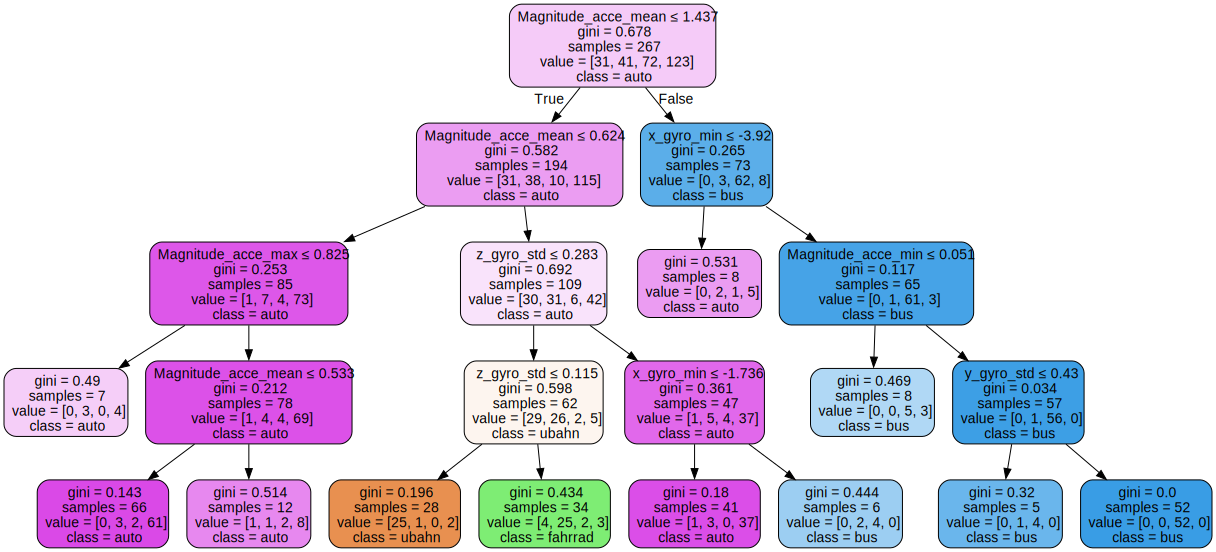

In [325]:
import graphviz
dot_data = tree.export_graphviz(clf_model,
                                out_file=None, 
                      feature_names=feature_names,  
                      class_names=target,  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  

graph

In [202]:
import pickle 
import torch
# save the model to disk
filename = 'MaennerML/Tree_Model.pkl'

with open(filename, 'wb') as file:  
    torch.save(classifier_decision_tree, file)


### Random Forest Classification

In [114]:
#randomforest
from sklearn.ensemble import RandomForestClassifier
rf_model= RandomForestClassifier()
rf_model.fit(X_train,y_train)
rf_predictions = rf_model.predict(X_test)
y_pred = clf_model.predict(X_test)

In [117]:
#Calculate accuracy
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
acccuracy = accuracy_score(y_test,y_pred)
print("Accuracy of Random Forest Classifier: " + str(acccuracy))
#print(classification_report(y_test, y_predict))

Accuracy of Random Forest Classifier: 0.8602150537634409


In [116]:
# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

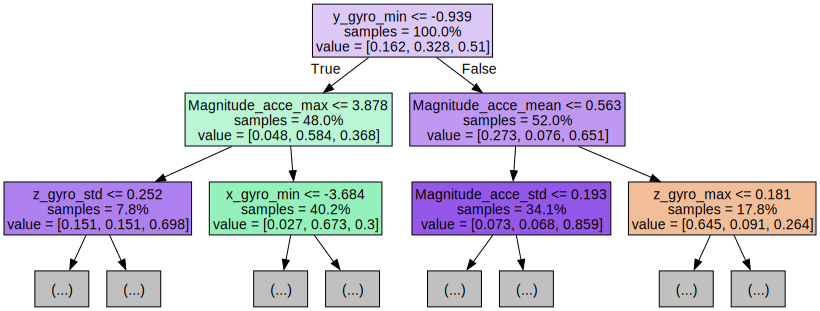

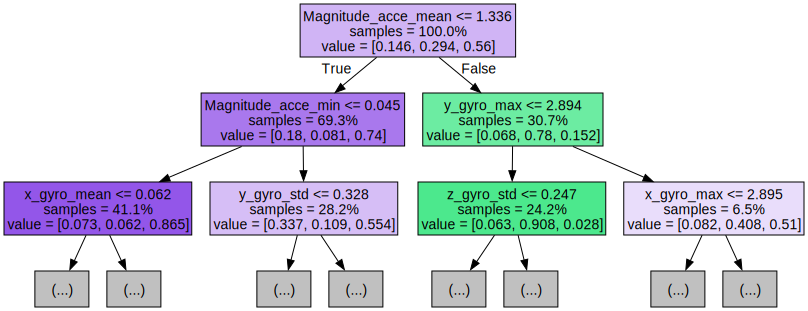

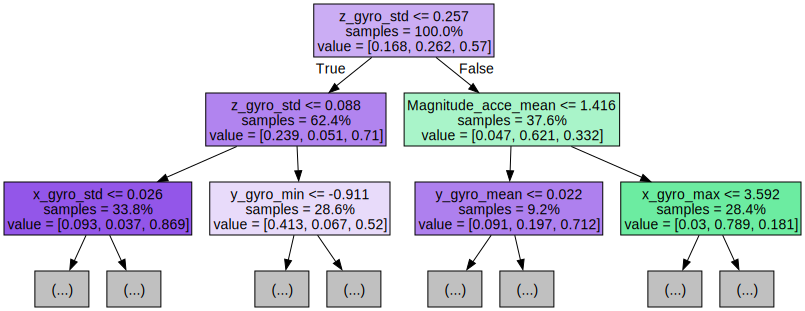

In [55]:
for i in range(3):
    tree = rf_model.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph )

## k-NN

In [235]:
df_completed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 347 entries, 2023-05-24 06:22:00 to 1970-01-01 00:28:00
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Magnitude_acce_min   347 non-null    float64
 1   z_gyro_min           347 non-null    float64
 2   y_gyro_min           347 non-null    float64
 3   x_gyro_min           347 non-null    float64
 4   Magnitude_acce_max   347 non-null    float64
 5   z_gyro_max           347 non-null    float64
 6   y_gyro_max           347 non-null    float64
 7   x_gyro_max           347 non-null    float64
 8   Magnitude_acce_mean  347 non-null    float64
 9   z_gyro_mean          347 non-null    float64
 10  y_gyro_mean          347 non-null    float64
 11  x_gyro_mean          347 non-null    float64
 12  Magnitude_acce_std   347 non-null    float64
 13  z_gyro_std           347 non-null    float64
 14  y_gyro_std           347 non-null    float64
 15  x_g

In [253]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils._testing import ignore_warnings

@ignore_warnings(category=ConvergenceWarning)
# Create k-fold validation set train-test split in the ratio of 90:10.
def kfold_train_test_split(data, target):
    """
    Create k-fold validation set train-test split in the ratio of 90:10.
    """
    X_traincv, X_test, y_traincv, y_test = train_test_split(data, target, test_size=0.1, random_state=42)
    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    
    for train_index, test_index in kf.split(X_traincv):
        X_train, X_cv = X_traincv.iloc[train_index], X_traincv.iloc[test_index]
        y_train, y_cv = y_traincv.iloc[train_index], y_traincv.iloc[test_index]
    return X_train, X_cv, y_train, y_cv

In [254]:
#separating labels and predictors
X = df_completed.drop('Type',axis=1)
X = X.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x))) #normalize the data in the summary dataframe.
y = df_completed['Type']

In [257]:
from sklearn.decomposition import PCA
n = 15
pca = PCA(n_components = n, random_state = 0)
pca.fit(X)
X_pca = pd.DataFrame(pca.transform(X))

In [258]:
print('The number of explained variance when n={} is {}' .format(n, sum(pca.explained_variance_ratio_)))

The number of explained variance when n=15 is 0.9981863678392193


In [259]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2, random_state = 0)
pca.fit(X)
X_pca = pd.DataFrame(pca.transform(X))
y_pca=y.reset_index(drop=True)

n = 10
pca = PCA(n_components = n, random_state = 0)
pca.fit(X)
X_pca = pd.DataFrame(pca.transform(X))

In [260]:
print('The number of explained variance when n={} is {}' .format(n, sum(pca.explained_variance_ratio_)))

The number of explained variance when n=10 is 0.9721055789622834


In [261]:
X_train, X_cv, y_train, y_cv = kfold_train_test_split(X_pca, y_pca)

In [262]:
from sklearn.metrics import f1_score, accuracy_score
def score(Classifier, X_testset, y_testset, option):
    y_pred = Classifier.predict(X_testset)
    if option == 'f1': 
        score =  f1_score(y_testset, y_pred, average='macro')
        print ("F1-Score on CV set is {}" .format(round(score,4)))
    elif option == 'accuracy':
        score =  accuracy_score(y_testset, y_pred)
        print ("Accuracy Score on CV set is {}" .format(round(score,4)))
    return score

In [267]:
from sklearn.neighbors import KNeighborsClassifier
@ignore_warnings(category=ConvergenceWarning)
def KNearestNeighbor():
    """
    Use KNearestNeighbor('f1') or KNearestNeighbor('accuracy')
    to print the F1- or accuracy scores for different k on the 
    training set.
    """
    print ("For KNN:")
    for i in [1,2,3,4,5,6,7,8,9,10,100,200, 250]:
        print ("\nWhen k = {}". format(i))
        KNN = KNeighborsClassifier(i)
        KNN.fit(X_train, y_train)
        y_pred = KNN.predict(X_cv)
        print("F1 score is {}" .format(round(f1_score(y_cv, y_pred, average='macro'),4)))

In [264]:
import sklearn
def SVC():
    """
    Use KNearestNeighbor('f1') or KNearestNeighbor('accuracy')
    to print the F1- or accuracy scores for different k on the 
    training set.
    """
    print ("For KNN:")
    for i in [0.01,0.1,1,2,3,4,5,6,7,8]:
        print ("\nWhen C = {}". format(i))
        svc = sklearn.svm.SVC(C=i, random_state=0, class_weight = 'balanced', gamma='scale')
        svc.fit(X_train, y_train.values.ravel())
        y_pred = svc.predict(X_cv)
        print(f1_score(y_cv, y_pred, average='macro'))

In [265]:
from sklearn.svm import LinearSVC
def LSVC():
    """
    Use KNearestNeighbor('f1') or KNearestNeighbor('accuracy')
    to print the F1- or accuracy scores for different k on the 
    training set.
    """
    print ("For KNN:")
    for i in [1,2,3,4,5,6,7,8,9,10,100,200,300]:
        print ("\nWhen C = {}". format(i))
        svc = LinearSVC(C=i, random_state=0, class_weight = 'balanced', dual = False, max_iter = 1000)
        svc.fit(X_train, y_train.values.ravel())
        y_pred = svc.predict(X_cv)
        print(f1_score(y_cv, y_pred, average='macro'))

In [268]:
y_pred = KNearestNeighbor()

For KNN:

When k = 1
F1 score is 0.7574

When k = 2
F1 score is 0.6714

When k = 3
F1 score is 0.7838

When k = 4
F1 score is 0.7526

When k = 5
F1 score is 0.8097

When k = 6
F1 score is 0.8097

When k = 7
F1 score is 0.8266

When k = 8
F1 score is 0.8266

When k = 9
F1 score is 0.8266

When k = 10
F1 score is 0.8266

When k = 100
F1 score is 0.4097

When k = 200
F1 score is 0.163

When k = 250
F1 score is 0.163


In [269]:
red_svc = SVC() #for unsliced data.

For KNN:

When C = 0.01
0.09740259740259741

When C = 0.1
0.3939393939393939

When C = 1
0.6908384043272481

When C = 2
0.712611567924661

When C = 3
0.725645813881108

When C = 4
0.725645813881108

When C = 5
0.712611567924661

When C = 6
0.712611567924661

When C = 7
0.725645813881108

When C = 8
0.725645813881108


In [270]:
LSVC()

For KNN:

When C = 1
0.6910014005602241

When C = 2
0.6910014005602241

When C = 3
0.6651877168777958

When C = 4
0.6651877168777958

When C = 5
0.6651877168777958

When C = 6
0.6651877168777958

When C = 7
0.6651877168777958

When C = 8
0.6651877168777958

When C = 9
0.6651877168777958

When C = 10
0.6651877168777958

When C = 100
0.6218189804943537

When C = 200
0.6218189804943537

When C = 300
0.6218189804943537


In [271]:
y_naive = ['MRT'] * len(y_cv)
#score =  f1_score(y_cv, y_naive, average='macro')
#score =  accuracy_score(y_cv, y_naive)
accuracy =  accuracy_score(y_cv, y_naive)
accuracy

0.0

In [272]:
SVC = sklearn.svm.SVC(C=7, random_state=0, class_weight = 'balanced', gamma='scale')
SVC.fit(X_train, y_train.values.ravel())
y_pred = SVC.predict(X_cv)

In [243]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title='Normalized confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
   # classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
 
    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

Normalized confusion matrix
[[0.86 0.   0.   0.14]
 [0.2  0.5  0.   0.3 ]
 [0.   0.   0.73 0.27]
 [0.07 0.07 0.03 0.83]]


<AxesSubplot: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

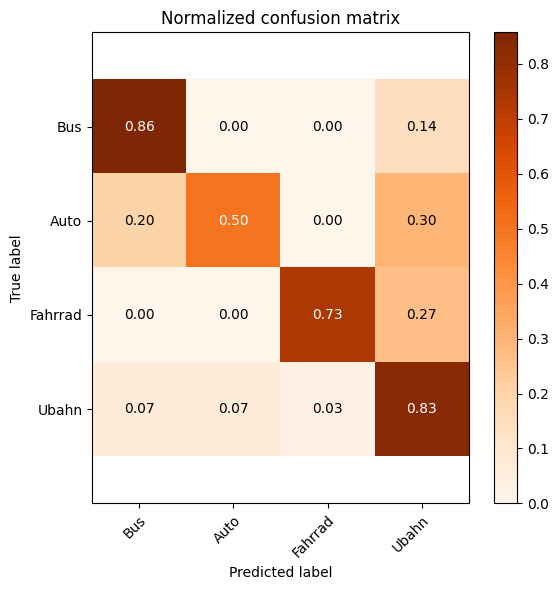

In [245]:
plot_confusion_matrix(y_cv, y_pred, classes = ['Bus', 'Auto', 'Fahrrad', 'Ubahn'], normalize = True)